An implementation BertViz's model_view. With this tool it is possible to visualize the self-attention mechanism for BERT and RoBERTa. Furthermore, we have implemented LUKE's *entity-aware* self-attention. We also provide the head_view for the visualization. 

Note, we provide a sample dataset to play around with (*data_dir*) but you can easily generate your own samples. Please follow the instruction on the Git page for further intructions.  


BertViz repo: https://github.com/jessevig/bertviz //
LUKE repo: https://github.com/studio-ousia/luke

In [1]:
data_dir = "sample_data/output_attentions.p"

# Import Packages and define functions

In [2]:
from bertviz import model_view
from transformers import BertTokenizer, BertModel, RobertaModel, RobertaTokenizer
import pickle
from bertviz.util import drop_down, sentence_index, print_sentence, get_entity_string, only_mask_attention, format_special_chars, plot_attention_token2token

In [3]:
def show_model_view(model, tokenizer, sentence_a, sentence_b=None, hide_delimiter_attn=False, display_mode="dark", format_attention=True):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)  
    if hide_delimiter_attn:
        for i, t in enumerate(tokens):
            if t in ("[SEP]", "[CLS]"):
                for layer_attn in attention:
                    layer_attn[0, :, i, :] = 0
                    layer_attn[0, :, :, i] = 0
    model_view(attention, tokens, sentence_b_start, display_mode=display_mode, format_data=format_attention)

# Load model and LUKE data

In [4]:
luke_data = pickle.load( open( f"{data_dir}", "rb" ))
sentences = [luke_data[sent]["sentence"] for sent in luke_data.keys()]

luke_data = get_entity_string(luke_data)
sentences_with_entity = [luke_data[sent]["sentence_with_entity"] for sent in luke_data]

# Model View
The model view gives a birds-eye view of attention across all of the layers (rows) and heads (columns) in the model. In this case we are showing *bert-base*, which has 12 layers and 12 heads (zero-indexed). 

## Usage
* **Click** on any **cell** for a detailed view of attention for the associated attention head.
* Then **hover** over any **token** on the left side of detail view to filter the attention from that token.
* The lines show the attention from each token (left) to every other token (right). Darker lines indicate higher attention weights.  

### Run cell 👇🏼 and then simple use the dropdown to select the sentence of interest

In [5]:
sentence_select = drop_down(options=sentences_with_entity)
display(sentence_select)

Dropdown(description='Select:', options=('Beyonce lives in Los Angeles . [entity:Los Angeles]', 'Beyonce lives…

### (re-run below cell when updating the dropdown)

In [7]:
model_version_bert = 'bert-base-uncased'
model_version_roberta = 'roberta-base'
output_attentions=True
do_lower_case = True

sentence_a = sentence_select.value[:sentence_select.value.find("[")-1]
sentence_b = None

# BERT model
model_bert = BertModel.from_pretrained(model_version_bert, output_attentions=True)
tokenizer_bert = BertTokenizer.from_pretrained(model_version_bert, do_lower_case=do_lower_case)
# RoBERTa: 
model_roberta = RobertaModel.from_pretrained(model_version_roberta, output_attentions=True)
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_version_roberta)
# LUKE
entity = sentence_select.value[sentence_select.value.find("[")+8:-1]
index = sentence_index(luke_data, sentence_a, entity)
tokens_luke = luke_data[f"sent_{index}"]["tokens"]
attention_luke = luke_data[f"sent_{index}"]["attention"]
attention_luke_only_mask = only_mask_attention(attention_luke.clone().detach())

# Tokens for other Token-2-Token plot:
tokens_in_sentence = format_special_chars(luke_data[f"sent_{index}"]["tokens"])

print_sentence(sentence_a, sentence_b)
print(f"\n")
print(f"Model: {model_version_bert}")
show_model_view(model_bert, tokenizer_bert, sentence_a, sentence_b, hide_delimiter_attn=False, display_mode="dark", format_attention=True)
print(f"\n")

print(f"\n")
print(f"Model: {model_version_roberta}")
show_model_view(model_roberta, tokenizer_roberta, sentence_a, sentence_b, hide_delimiter_attn=False, display_mode="dark", format_attention=True)

print(f"\n")
print(f"Model: LUKE")
model_view(attention_luke, tokens_luke, format_data=False)
print(f"Model: LUKE (only showing MASK attention scores")
model_view(attention_luke_only_mask, tokens_luke, format_data=False)


Sentence: Beyonce lives in Los Angeles .


Model: bert-base-uncased


<IPython.core.display.Javascript object>





Model: roberta-base


<IPython.core.display.Javascript object>



Model: LUKE


<IPython.core.display.Javascript object>

Model: LUKE (only showing MASK attention scores


<IPython.core.display.Javascript object>

# Look at Token-to-Token attention for LUKE throughout layers
### Use the dropdowns 👇🏼 to selecet Token_1 and Token_2 at see the average head attention (line, where each dot represents an attention head). 

##### Note, the implementation is meant for unique tokens (it is case sensitive, i.e. "The" and "the" are different). 

In [10]:
token1 = drop_down(options=tokens_in_sentence, description="Token 1 $\longrightarrow$")
token2 = drop_down(options=tokens_in_sentence, description="$\longrightarrow$ Token 2")
display(token1); display(token2)

Dropdown(description='Token 1 $\\longrightarrow$', options=('<s>', 'The', 'doctor', 'asked', 'the', 'nurse', '…

Dropdown(description='$\\longrightarrow$ Token 2', options=('<s>', 'The', 'doctor', 'asked', 'the', 'nurse', '…

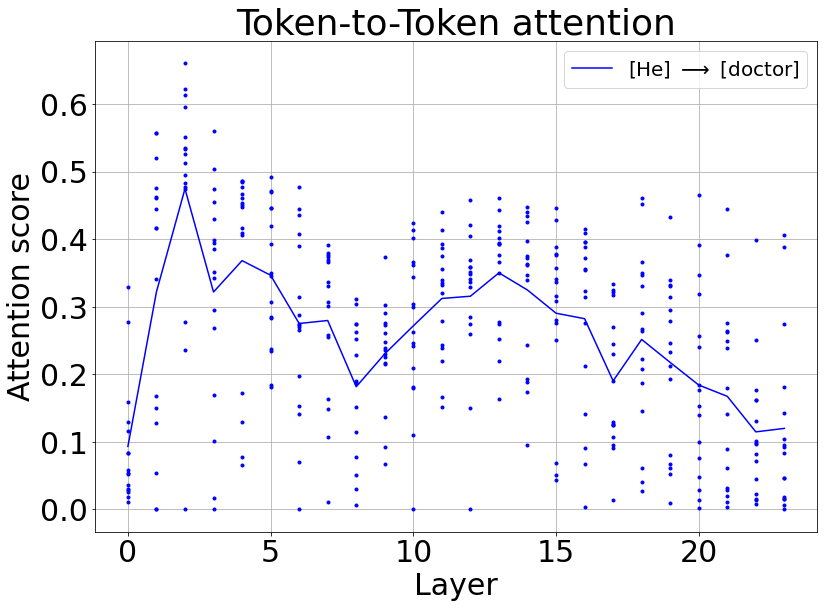

In [11]:
plot = plot_attention_token2token(tokens_in_sentence, attention_luke, token1.value, token2.value)